In [25]:
import pandas as pd

In [26]:

from pprint import pprint
import matplotlib.pyplot as plt

import numpy as np
### LDA MODELING
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
### WordCloud
from wordcloud import WordCloud

# LDA visualizations
import pyLDAvis.sklearn

In [27]:
data = pd.read_csv('/Users/alessandro/Downloads/venezuela_201906_1_tweets_csv_hashed.csv')


In [28]:
tweets_mask = data['is_retweet'] == False
tweets = data[tweets_mask]

tweets_english = tweets[tweets['tweet_language'] == 'en']

In [29]:
user_df = tweets_english[['tweetid', 'userid', 'user_screen_name', 'user_reported_location', 'follower_count', 'tweet_text']]

In [30]:
len(user_df['userid'].unique())


33

In [31]:
tweets_english['tweet_text'].sample(6)

445984    BREAKING: Trump Signs Deal To Host The Tonight...
74924     WATCH: Ocasio-Cortez Attacks Israel, Then Stut...
515724    Jill Stein is KICKING Another FUSS with the Ph...
528694    Top Trump Strategist’s Message To The “Deplora...
466829    5 things you need to know Friday https://t.co/...
196097    ▷ Judge Judy Weighs In on the Kavanaugh Scanda...
Name: tweet_text, dtype: object

In [32]:
user_df.head()


,tweetid,userid,user_screen_name,user_reported_location,follower_count,tweet_text
0,841279580644171777,828668571765133317,TRUMPTRAIN_17,"Texas, USA",5059,Truth About “Right to Healthcare” Every Lib Ne...
1,933065474744684544,892133369965944833,Laureen4Trump,NaN,40710,"BREAKING: Air Force Makes Tragic Announcement,..."
2,1020373357144018945,892133369965944833,Laureen4Trump,NaN,40710,HAPPENING NOW: Disney Facing a Scandal So Cata...
3,927862406268751872,896121971989262336,EmmaTurnerBN,NaN,34770,Another Stupid Gun Control Cartoon From the Le...
4,845268272664633345,768237282562310144,GODBLESSAMERIC,"Washington, DC",15246,➡️ 90 POUNDS OF COCAINE FOUND ON SHIP OWNED BY...


In [33]:
users_tweets_series = user_df.groupby(['userid']).apply(lambda x:" ".join(x.tweet_text))


In [34]:
users_tweets = pd.DataFrame( users_tweets_series ).reset_index()


In [35]:
users_tweets.columns = ['userid', 'tweets_text']


In [36]:
users_tweets.head()


,userid,tweets_text
0,55DeTN4VJIeKfM9Atr0sSTLomZbJyUWuBNdDK2an1nE=,https://t.co/vl4Opjw6Ht @Ethereum Community#ET...
1,568620329,“Troubled times” videoclip anti-Trump de Green...
2,741092772233482241,"Fact-Check: No, Hillary Clinton Does Not Suppo..."
3,741112500356276225,'Not my president' protests prompt... https://...
4,751630413769113601,Update: Fort Lauderdale Airport Shooting – “Te...


In [37]:
### Creating a function to clean_up the twitter_text
#### ALL WORKS!!!!
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

#Additional
import string
string.punctuation

# In this edit I didn't remove # and @ hoping to find the way to remove it together with the followings
punct = set(string.punctuation)
punct.remove('@')
punct.remove('#')






lemmer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')


### STOP WORDS --  combining w/custom list of most frequently used and uninformative words (see news_stop_words)
stop_words = set(nltk.corpus.stopwords.words('english')) 

### I HAVE THIS INSIDE THE FUNCTION AS WELL, NEED TO TEST IF WORKS IF REMOVE FROM HERE
new_stop_words = {'rt', 'hey' 'via', 'new', 'time', 'today', 'one', 'say', 'get', 'go', 
                  'im', 'know', 'need', 'made', 'https', 'http', 'that', 'would', 
                  'take', 'your', 'two', 'yes', 'back', 'look', 'see', 'amp', 'tell',
                  'give', 'httpst', 'htt', 'use', 'dont', 'thing', 'man', 'thank', 'lol', 'cc', 'agre' }

import preprocessor as p
import re

def preprocessing_text(text):
    '''
    INPUT: str
    OUTPUT: str w/ emojies, urls, hashtags and mentions removed
    '''
    p.set_options(p.OPT.EMOJI, p.OPT.URL, p.OPT.HASHTAG, p.OPT.MENTION, p.OPT.NUMBER, p.OPT.RESERVED, p.OPT.SMILEY)
    clean_text = p.clean(text)
    
    return clean_text

def remove_symbols(word, symbol_set):
    
    '''
    Removing symbols from word
    '''
    return ''.join(char for char in word 
                    if char not in symbol_set)

def clean_tweet_text(text_column):
    '''
    takes a columns in dataframe with tweets text: 
    Outputs: PD Series of tokenized docs
    lower case, 
    symbol_set charachters removed,
    specified stop words removed
    punctuation removed
    words stemmed and lemmatized
    
    '''
    
    
    # converting from pd to list
    corpus = text_column.values.tolist()
    
    #Removing all HTTPs
    docs_no_http = [ re.sub(r'https?:\/\/.*\/\w*', '', doc) for doc in corpus ]
    #First ---> tokenize docs
    tokenized_docs = [doc.split() for doc in docs_no_http]
    # Lower case words in doc
    tokenized_docs_lowered  = [[word.lower() for word in doc]
                                for doc in tokenized_docs]

    # Removing punctuation from docs
    cleaned_docs = [[remove_symbols(word, punct) for word in doc] 
                    for doc in tokenized_docs_lowered]

    ### Removing stop words
#     stop_words = set(nltk.corpus.stopwords.words('english'))


    stop_words = set(nltk.corpus.stopwords.words('english'))

    new_stop_words = {'rt', 'via', 'new', 'time', 'today', 'one', 'say', 'get', 'go', 
                      'im', 'know', 'need', 'made', 'https', 'http', 'that', 'would', 
                      'take', 'your', 'two', 'yes', 'back', 'look', 'see', 'amp', 'tell',
                      'give', 'httpst', 'htt', 'use', 'dont', 'thing', 'man', 'thank'}

    
    docs_no_stops1 = [[word for word in doc if word not in new_stop_words] 
                     for doc in cleaned_docs]
    
    docs_no_stops = [[word for word in doc if word not in stop_words ] 
                     for doc in docs_no_stops1]
    # Lemmatize words in docs
    docs_lemmatized = [[lemmer.lemmatize(word) for word in doc]
                      for doc in docs_no_stops]
    
#     # Stem words in docs
#     docs_stemmed = [[stemmer.stem(word) for word in doc]
#                       for doc in docs_lemmatized]
    
    # Removes mentions, emotions, hashtags and emojies
    docs_no_mentions = [preprocessing_text(' '.join(doc)) for doc in docs_lemmatized]
    
    bag = []
    for doc in docs_no_mentions:
        if len(doc) >= 2:
            bag.append(doc)
    
    # converts into list of lists
    bow = [list(tweet.split(' ')) for tweet in bag]
    
    
    # convert docs into pd series
    full_service_docs_series = pd.Series( (v[0] for v in bow) )
    
    # changed docs stemmed to docs lemmatized
    return bag, bow, docs_lemmatized, full_service_docs_series


In [38]:
user_tweet_bag, user_tweet_bow, user_tweet_docs_lemmatized, user_tweet_full_service_docs_series = clean_tweet_text(users_tweets['tweets_text'])


In [39]:
user_tweet_bow[1]

['“troubled', 'times”', 'videoclip', 'antitrump', 'de', 'green', 'day']

In [40]:
no_features = 20000

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf_lda = tf_vectorizer.fit_transform(user_tweet_bag)
tf_feature_names = tf_vectorizer.get_feature_names()

In [41]:
no_topics = 3

# Run LDA
lda_1 = LatentDirichletAllocation(n_components=no_topics,            # Number of topics 
                                  max_iter=10,                    # Max learning iterations
                                  learning_method='online',
                                  learning_decay=0.9,
                                  learning_offset=50.,
                                  evaluate_every = -1,           # compute perplexity every n iters, default: Don't 
                                  n_jobs = -1,
                                  random_state=0).fit(tf_lda)



lda_output = lda_1.fit_transform(tf_lda)
print(lda_1)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.9,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=3, n_jobs=-1,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [42]:

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d: " % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 25
display_topics(lda_1, tf_feature_names, no_top_words)

Topic 0: 
sickening stupid manafort blunder user dear control support judge lie audio hi going la kelly everyones left end agent damn didn affair reveals response tore
Topic 1: 
trump hillary breaking stand make clinton america obama penny donald mike supporting great president poll debate end support movement help god history want white ben
Topic 2: 
hillary trump breaking want penny dead god clinton shooting obama hope love round white history meeting support world make words instantly debate al traitor doesnt


# Checking for Sparsity


In [43]:
# Materialize the sparse data
data_dense = tf_lda.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  24.676644493717664 %


# Diagnose model performance with perplexity and log-likelihood


In [44]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_1.score(tf_lda))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_1.perplexity(tf_lda))

# See model parameters
pprint(lda_1.get_params())

Log Likelihood:  -24325.188737673336
Perplexity:  261.492275916102
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.9,
 'learning_method': 'online',
 'learning_offset': 50.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 3,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [45]:

# Defining Search Parameters
search_params = {'n_components': [3, 4, 5, 6, 7, 8, 10], 'learning_decay': [0.01, 0.1, .5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf_lda)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [46]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf_lda))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 3}
Best Log Likelihood Score:  -10524.998977530342
Model Perplexity:  204.72189126498333


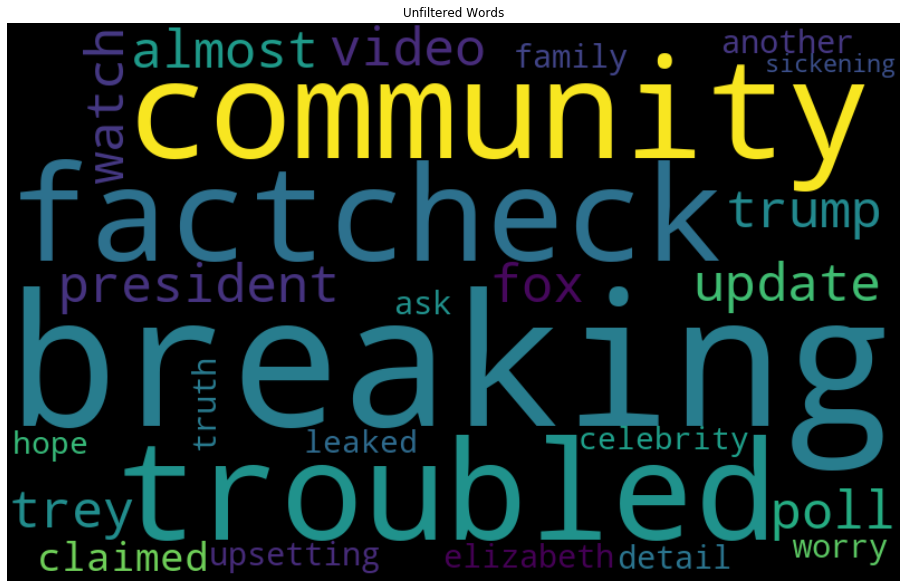

In [47]:
all_words = ' '.join([text for text in user_tweet_full_service_docs_series])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=200, stopwords = ['hey', 'lol', '[][]', 'cc', 'anyon', 'say', 'etc']).generate(all_words)

plt.figure(figsize=(16, 16))
plt.imshow(wordcloud, interpolation="bilinear", cmap = 'inferno')
plt.axis('off')
plt.title('Unfiltered Words')
plt.show()

In [48]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, tf_lda, tf_vectorizer, mds='tsne')
panel
## x-axis --> two components that capture most ammount of variance!

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
1      -632.045471 -384.325073       1        1  79.680057
0     -1209.665405  212.164124       2        1  19.774323
2     -1437.453247 -586.322510       3        1   0.545619, topic_info=    Category        Freq          Term       Total  loglift  logprob
298  Default  298.000000         trump  298.000000  30.0000  30.0000
272  Default   64.000000         stand   64.000000  29.0000  29.0000
115  Default   38.000000         great   38.000000  28.0000  28.0000
178  Default   66.000000          make   66.000000  27.0000  27.0000
6    Default   62.000000       america   62.000000  26.0000  26.0000
282  Default   39.000000    supporting   39.000000  25.0000  25.0000
27   Default  105.000000      breaking  105.000000  24.0000  24.0000
191  Default   29.000000      movement   29.000000  23.0000  23.0000
213  Default   24.000000        people   24.000000  22.0000  22.0000
127  Default   29.000000       history   29.000000  21.0000  21.0000
126  Default  143.000000       hillary  143.000000  20.0000  20.0000
199  Default   52.000000         obama   52.000000  19.0000  19.0000
147  Default    8.000000          join    8.000000  18.0000  18.0000
217  Default   35.000000          poll   35.000000  17.0000  17.0000
43   Default    8.000000         check    8.000000  16.0000  16.0000
55   Default    8.000000       control    8.000000  15.0000  15.0000
291  Default    8.000000      thousand    8.000000  14.0000  14.0000
47   Default   67.000000       clinton   67.000000  13.0000  13.0000
212  Default   53.000000         penny   53.000000  12.0000  12.0000
77   Default   48.000000        donald   48.000000  11.0000  11.0000
186  Default   47.000000          mike   47.000000  10.0000  10.0000
64   Default   37.000000        debate   37.000000   9.0000   9.0000
280  Default   33.000000       support   33.000000   8.0000   8.0000
83   Default   35.000000           end   35.000000   7.0000   7.0000
219  Default   37.000000     president   37.000000   6.0000   6.0000
109  Default   32.000000           god   32.000000   5.0000   5.0000
311  Default   31.000000          want   31.000000   4.0000   4.0000
318  Default   28.000000         white   28.000000   3.0000   3.0000
22   Default   22.000000     bombshell   22.000000   2.0000   2.0000
35   Default   24.000000        carson   24.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
147   Topic3    0.437145          join    8.812733   2.2073  -3.9990
55    Topic3    0.249536       control    8.628127   1.6678  -4.5597
291   Topic3    0.249473      thousand    8.628384   1.6675  -4.5599
43    Topic3    0.249380         check    8.629060   1.6671  -4.5603
131   Topic3    0.071071          hope    2.472798   1.6616  -5.8156
261   Topic3    0.066767      shooting    2.487374   1.5932  -5.8781
62    Topic3    0.064653          deal    2.431079   1.5839  -5.9102
26    Topic3    0.067239           boy    2.599181   1.5563  -5.8710
61    Topic3    0.065600          dead    2.605598   1.5292  -5.8957
39    Topic3    0.062428       changed    2.528677   1.5096  -5.9453
197   Topic3    0.062365        number    2.618945   1.4735  -5.9463
48    Topic3    0.062425           cnn    3.408213   1.2110  -5.9453
194   Topic3    0.062376          news    3.588873   1.1586  -5.9461
63    Topic3    0.062833          dear    4.248640   0.9971  -5.9388
99    Topic3    0.062364        follow    4.559613   0.9190  -5.9463
120   Topic3    0.062364       hashtag    4.560068   0.9189  -5.9463
238   Topic3    0.062426       retweet    5.426630   0.7459  -5.9453
174   Topic3    0.063484          love    5.526300   0.7445  -5.9285
213   Topic3    0.244575        people   24.156203   0.6182  -4.5797
299   Topic3    0.062368    trumpsters    7.471249   0.4252  -5.9462
171   Topic3    0.062364          load    7.471577   0.4251  -5.9463
115  

In [49]:
from sklearn.decomposition import NMF


# Use Gensim for my LDA model


In [50]:

import gensim
import gensim.corpora as corpora

from gensim.models import CoherenceModel

import pyLDAvis.gensim


# # Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [51]:
# Create Dictionary
id2word = corpora.Dictionary(user_tweet_bow) # user_tweet_bow

# Create Corpus
texts = user_tweet_bow


# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)]]


In [52]:
id2word[3]

'ceo'

In [53]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('airdrop', 3),
  ('along', 1),
  ('already”', 1),
  ('ceo', 1),
  ('check', 1),
  ('communication', 1),
  ('community', 1),
  ('country', 1),
  ('dapps', 1),
  ('dubtokens', 1),
  ('especially', 1),
  ('free', 1),
  ('future', 1),
  ('giveaway', 2),
  ('great', 1),
  ('hello', 1),
  ('impressed', 1),
  ('interview', 1),
  ('join', 2),
  ('long', 1),
  ('no1', 1),
  ('now', 1),
  ('open', 1),
  ('people', 1),
  ('please', 1),
  ('privacy', 1),
  ('product', 1),
  ('profitable', 1),
  ('project', 1),
  ('roadmap', 1),
  ('secure', 1),
  ('still', 1),
  ('super', 1),
  ('teamdco', 1),
  ('term', 1),
  ('thousand', 1),
  ('token', 2),
  ('trusted', 1),
  ('turn', 1),
  ('uk', 1),
  ('user', 1),
  ('website', 1),
  ('whitepaper', 1),
  ('working', 1),
  ('yondo', 1),
  ('“we', 1)]]

In [54]:
### Building LDA GENSIM Model

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [55]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.064*"please" + 0.064*"trump" + 0.062*"⤵️⤵️" + 0.062*"stand" + 0.062*"🇺🇸" '
  '+ 0.062*"click" + 0.033*"make" + 0.033*"great" + 0.033*"america" + '
  '0.033*"supporting"'),
 (1,
  '0.038*"️" + 0.033*"breaking" + 0.027*"trump" + 0.021*"poll" + 0.021*"obama" '
  '+ 0.013*"history" + 0.012*"people" + 0.012*"trey" + 0.012*"gowdy" + '
  '0.012*"end"'),
 (2,
  '0.053*"▶" + 0.047*"trump" + 0.031*"hillary" + 0.016*"breaking" + '
  '0.015*"clinton" + 0.012*"penny" + 0.011*"donald" + 0.010*"mike" + '
  '0.009*"make" + 0.008*"debate"')]


# Inferring Topics From Keywords (all very political) 5 topics
Topic 1: Unclear, Trump is mentioned.

Topic 2: Politics: with Mike mentioned, sickening, airdrop. Perhaps Syrian conflict.

Topic 3: Very Patriotic. Please is highest, trump second, american flag, hthe make america great gain is almost spelled out.

Topic 4: More politics. With Trey Gowdy (R-oversight) being mentnioned, trump obama.

Topic 5: More Politics: Clinton, donald, mike, debate. 

# Inferring Topics From Keywords (all very political) 3 topics
Topic 1: Politics Trump, American Flag, Make America Great again.

Topic 2: Politics: Trump Obama, Trey Gowdy (oversight committee) Obama.

Topic 3: Politics: Trump Hillary, mike pence, debare. 

Breaking in two of 3 topics.

In [56]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=user_tweet_bow, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.5479037779014

Coherence Score:  0.5622157096934409


In [57]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.099544  0.136436       1        1  74.795204
0      0.238797 -0.014331       2        1  12.690245
1     -0.139253 -0.122105       3        1  12.514557, topic_info=    Category        Freq         Term       Total  loglift  logprob
366  Default  279.000000        trump  279.000000  30.0000  30.0000
24   Default   63.000000       please   63.000000  29.0000  29.0000
339  Default   58.000000        stand   58.000000  28.0000  28.0000
540  Default   47.000000         ⤵️⤵️   47.000000  27.0000  27.0000
530  Default   47.000000        click   47.000000  26.0000  26.0000
503  Default   51.000000           🇺🇸   51.000000  25.0000  25.0000
83   Default   98.000000     breaking   98.000000  24.0000  24.0000
475  Default   46.000000            ️   46.000000  23.0000  23.0000
239  Default   64.000000         make   64.000000  22.0000  22.0000
61   Default   57.000000      america   57.000000  21.0000  21.0000
350  Default   37.000000   supporting   37.000000  20.0000  20.0000
14   Default   35.000000        great   35.000000  19.0000  19.0000
334  Default   32.000000      someone   32.000000  18.0000  18.0000
325  Default   35.000000         show   35.000000  17.0000  17.0000
445  Default   26.000000     movement   26.000000  16.0000  16.0000
529  Default   25.000000         care   25.000000  15.0000  15.0000
533  Default   25.000000         gift   25.000000  14.0000  14.0000
536  Default   25.000000      looking   25.000000  13.0000  13.0000
261  Default   47.000000        obama   47.000000  12.0000  12.0000
275  Default   31.000000         poll   31.000000  11.0000  11.0000
144  Default   33.000000          end   33.000000  10.0000  10.0000
348  Default   31.000000      support   31.000000   9.0000   9.0000
23   Default   21.000000       people   21.000000   8.0000   8.0000
395  Default   26.000000        white   26.000000   7.0000   7.0000
277  Default   35.000000    president   35.000000   6.0000   6.0000
410  Default  239.000000            ▶  239.000000   5.0000   5.0000
79   Default   19.000000    bombshell   19.000000   4.0000   4.0000
435  Default   13.000000      history   13.000000   3.0000   3.0000
465  Default   12.000000         trey   12.000000   2.0000   2.0000
429  Default   12.000000        gowdy   12.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
428   Topic3    8.439572        going   11.952584   1.7303  -4.4788
421   Topic3    8.439032   deepseated   11.952561   1.7302  -4.4788
458   Topic3    8.433892     sharpton   11.954423   1.7294  -4.4794
468   Topic3    8.427765  wiretapping   11.956065   1.7286  -4.4802
417   Topic3    8.410197       border   11.964737   1.7258  -4.4822
474   Topic3    8.392505         “the   11.971474   1.7231  -4.4844
431   Topic3    8.384085       hatred   11.974427   1.7218  -4.4854
438   Topic3    8.364457   impossible   11.984276   1.7187  -4.4877
461   Topic3    8.355865       signed   11.987204   1.7174  -4.4887
436   Topic3    8.333539     history’   11.997052   1.7139  -4.4914
447   Topic3    8.326723       obamas   11.999515   1.7129  -4.4922
463   Topic3    8.321221          tax   12.001124   1.7121  -4.4929
451   Topic3    8.319746      putting   12.003109   1.7117  -4.4931
423   Topic3    8.318294      evasion   12.003251   1.7116  -4.4932
471   Topic3    8.316724       ‘first   12.004705   1.7112  -4.4934
448   Topic3    8.298661      officer   12.011952   1.7085  -4.4956
464   Topic3    8.294703      treason   12.014865   1.7078  -4.4961
439   Topic3    8.290729   indictment   12.016542   1.7071  -4.4966
454   Topic3    8.284320      reveals   12.018283   1.7062  -4.4973
469   Topic3    8.269507       world”   12.024411   1.7039  -4.4991
441   Topic3    8.264876         jail   12.026386   1.7032  -4.4997
433   Topic3    8.257080        heard   12.029608   1.7020  -4.5006
475   Topic3   

In [58]:
mallet_path = '/Users/alessandro/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=3, id2word=id2word)

/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [59]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=user_tweet_bow, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('▶', 0.07107772320138689),
   ('trump', 0.05605316382548396),
   ('hillary', 0.04189540595203698),
   ('clinton', 0.019936434556486565),
   ('breaking', 0.018780699219878648),
   ('penny', 0.015602427044206876),
   ('donald', 0.014157757873446981),
   ('mike', 0.013868824039295001),
   ('debate', 0.01097948569777521),
   ('god', 0.009534816527015313)]),
 (1,
  [('️', 0.06483516483516484),
   ('breaking', 0.05054945054945055),
   ('obama', 0.046153846153846156),
   ('poll', 0.041758241758241756),
   ('white', 0.03296703296703297),
   ('people', 0.026373626373626374),
   ('bombshell', 0.025274725274725275),
   ('history', 0.01868131868131868),
   ('shot', 0.017582417582417582),
   ('trey', 0.017582417582417582)]),
 (2,
  [('trump', 0.13154831199068684),
   ('stand', 0.08381839348079162),
   ('america', 0.07683352735739232),
   ('🇺🇸', 0.07566938300349244),
   ('click', 0.0710128055878929),
   ('⤵️⤵️', 0.0710128055878929),
   ('make', 0.06868451688009314),
   ('supporting', 0.0512

In [60]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [61]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=user_tweet_bow, start=3, limit=40, step=2)

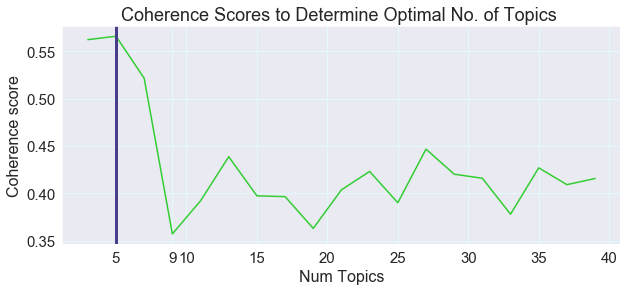

In [62]:
# Show graph
import seaborn as sns
limit=40; start=3; step=2;

x = range(start, limit, step)

plt.figure(figsize=(10,4))

sns.set_style("darkgrid")

plt.plot(x, coherence_values, c = 'limegreen')
plt.xlabel("Num Topics", fontsize = 16)
plt.ylabel("Coherence score", fontsize = 16)


plt.xticks((5, 9, 10, 15, 20, 25, 30, 35, 40), fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(c = 'lightcyan')

plt.axvline(x=5, c = 'darkslateblue', linewidth = 3.0)

plt.title('Coherence Scores to Determine Optimal No. of Topics ', fontsize = 18)
plt.show()

In [63]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.5622
Num Topics = 5  has Coherence Value of 0.5658
Num Topics = 7  has Coherence Value of 0.5215
Num Topics = 9  has Coherence Value of 0.3574
Num Topics = 11  has Coherence Value of 0.3923
Num Topics = 13  has Coherence Value of 0.4388
Num Topics = 15  has Coherence Value of 0.3975
Num Topics = 17  has Coherence Value of 0.3967
Num Topics = 19  has Coherence Value of 0.3632
Num Topics = 21  has Coherence Value of 0.4039
Num Topics = 23  has Coherence Value of 0.4232
Num Topics = 25  has Coherence Value of 0.3902
Num Topics = 27  has Coherence Value of 0.4468
Num Topics = 29  has Coherence Value of 0.4204
Num Topics = 31  has Coherence Value of 0.4161
Num Topics = 33  has Coherence Value of 0.3782
Num Topics = 35  has Coherence Value of 0.4271
Num Topics = 37  has Coherence Value of 0.4093
Num Topics = 39  has Coherence Value of 0.4158


In [64]:
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.064*"please" + 0.064*"trump" + 0.062*"⤵️⤵️" + 0.062*"stand" + 0.062*"🇺🇸" '
  '+ 0.062*"click" + 0.033*"make" + 0.033*"great" + 0.033*"america" + '
  '0.033*"supporting" + 0.033*"care" + 0.033*"show" + 0.033*"someone" + '
  '0.033*"looking" + 0.033*"movement"'),
 (1,
  '0.038*"️" + 0.033*"breaking" + 0.027*"trump" + 0.021*"poll" + 0.021*"obama" '
  '+ 0.013*"history" + 0.012*"people" + 0.012*"trey" + 0.012*"gowdy" + '
  '0.012*"end" + 0.012*"support" + 0.012*"corruption" + 0.011*"intel" + '
  '0.011*"al" + 0.011*"round"'),
 (2,
  '0.053*"▶" + 0.047*"trump" + 0.031*"hillary" + 0.016*"breaking" + '
  '0.015*"clinton" + 0.012*"penny" + 0.011*"donald" + 0.010*"mike" + '
  '0.009*"make" + 0.008*"debate" + 0.007*"help" + 0.007*"everyone" + '
  '0.007*"god" + 0.007*"obama" + 0.007*"america"')]


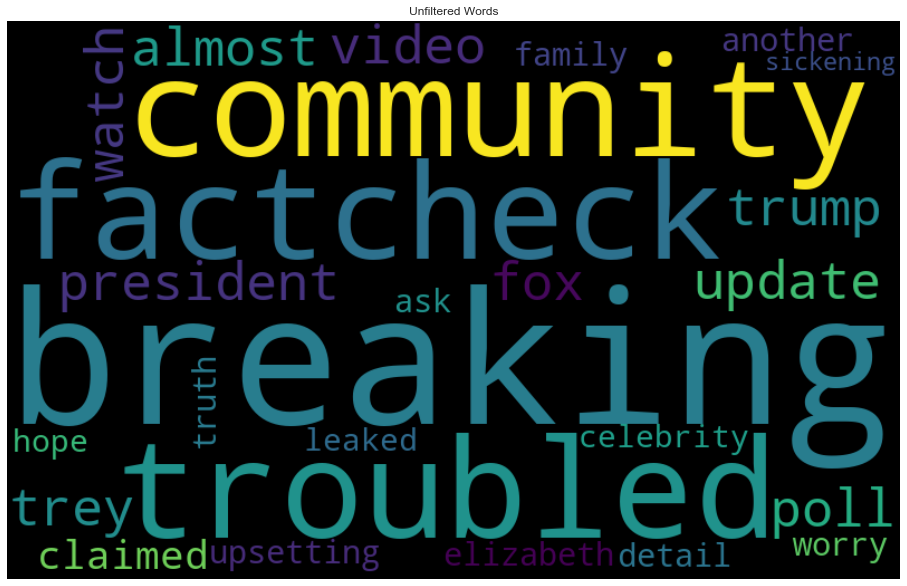

In [86]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=200, stopwords = ['hey', 'lol', '[][]', 'cc', 'anyon', 'say', 'etc']).generate(all_words)

plt.figure(figsize=(16, 16))
plt.imshow(wordcloud, interpolation="bilinear", cmap = 'inferno')
plt.axis('off')
plt.title('Unfiltered Words')
plt.show()

# 6. What is the Dominant topic and its percentage contribution in each document


In [66]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=user_tweet_bow)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9978,"️, breaking, trump, poll, obama, history, peop...","[community, long, term, hello, people, please,..."
1,1,1.0,0.9848,"️, breaking, trump, poll, obama, history, peop...","[“troubled, times”, videoclip, antitrump, de, ..."
2,2,2.0,0.9998,"▶, trump, hillary, breaking, clinton, penny, d...","[factcheck, hillary, clinton, support, nd, ame..."
3,3,2.0,0.9513,"▶, trump, hillary, breaking, clinton, penny, d...","[president, protest, prompt]"
4,4,2.0,0.9792,"▶, trump, hillary, breaking, clinton, penny, d...","[update, fort, lauderdale, airport, shooting, ..."
5,5,2.0,0.9764,"▶, trump, hillary, breaking, clinton, penny, d...","[▶, election, over…hillary, done, see, great, ..."
6,6,2.0,0.9766,"▶, trump, hillary, breaking, clinton, penny, d...","[poll, liberal, medium, purposely, skewing, tr..."
7,7,2.0,0.9758,"▶, trump, hillary, breaking, clinton, penny, d...","[️, pound, cocaine, found, ship, owned, rino, ..."
8,8,2.0,0.9751,"▶, trump, hillary, breaking, clinton, penny, d...","[️, trump, attend, governor, ball, academy, aw..."
9,9,2.0,0.9997,"▶, trump, hillary, breaking, clinton, penny, d...","[‘almost, ’, fbi, agent, join, mutiny, hillary..."


# The most representative sentence for each topic


In [67]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9997,"please, trump, ⤵️⤵️, stand, 🇺🇸, click, make, great, america, supporting","[breaking, comeyobama, collusion, uncovered, looking, gift, show, someone, care, supporting, mak..."
1,1.0,0.9982,"️, breaking, trump, poll, obama, history, people, trey, gowdy, end","[watch, cnn, brings, ben, stein, talk, trump…, end, destroying, cnn, instead, ️, breaking, trey,..."
2,2.0,0.9998,"▶, trump, hillary, breaking, clinton, penny, donald, mike, make, debate","[factcheck, hillary, clinton, support, nd, amendment, everyone, vote, donald, trump, right, enti..."


# Frequency Distribution of Word Counts in Documents


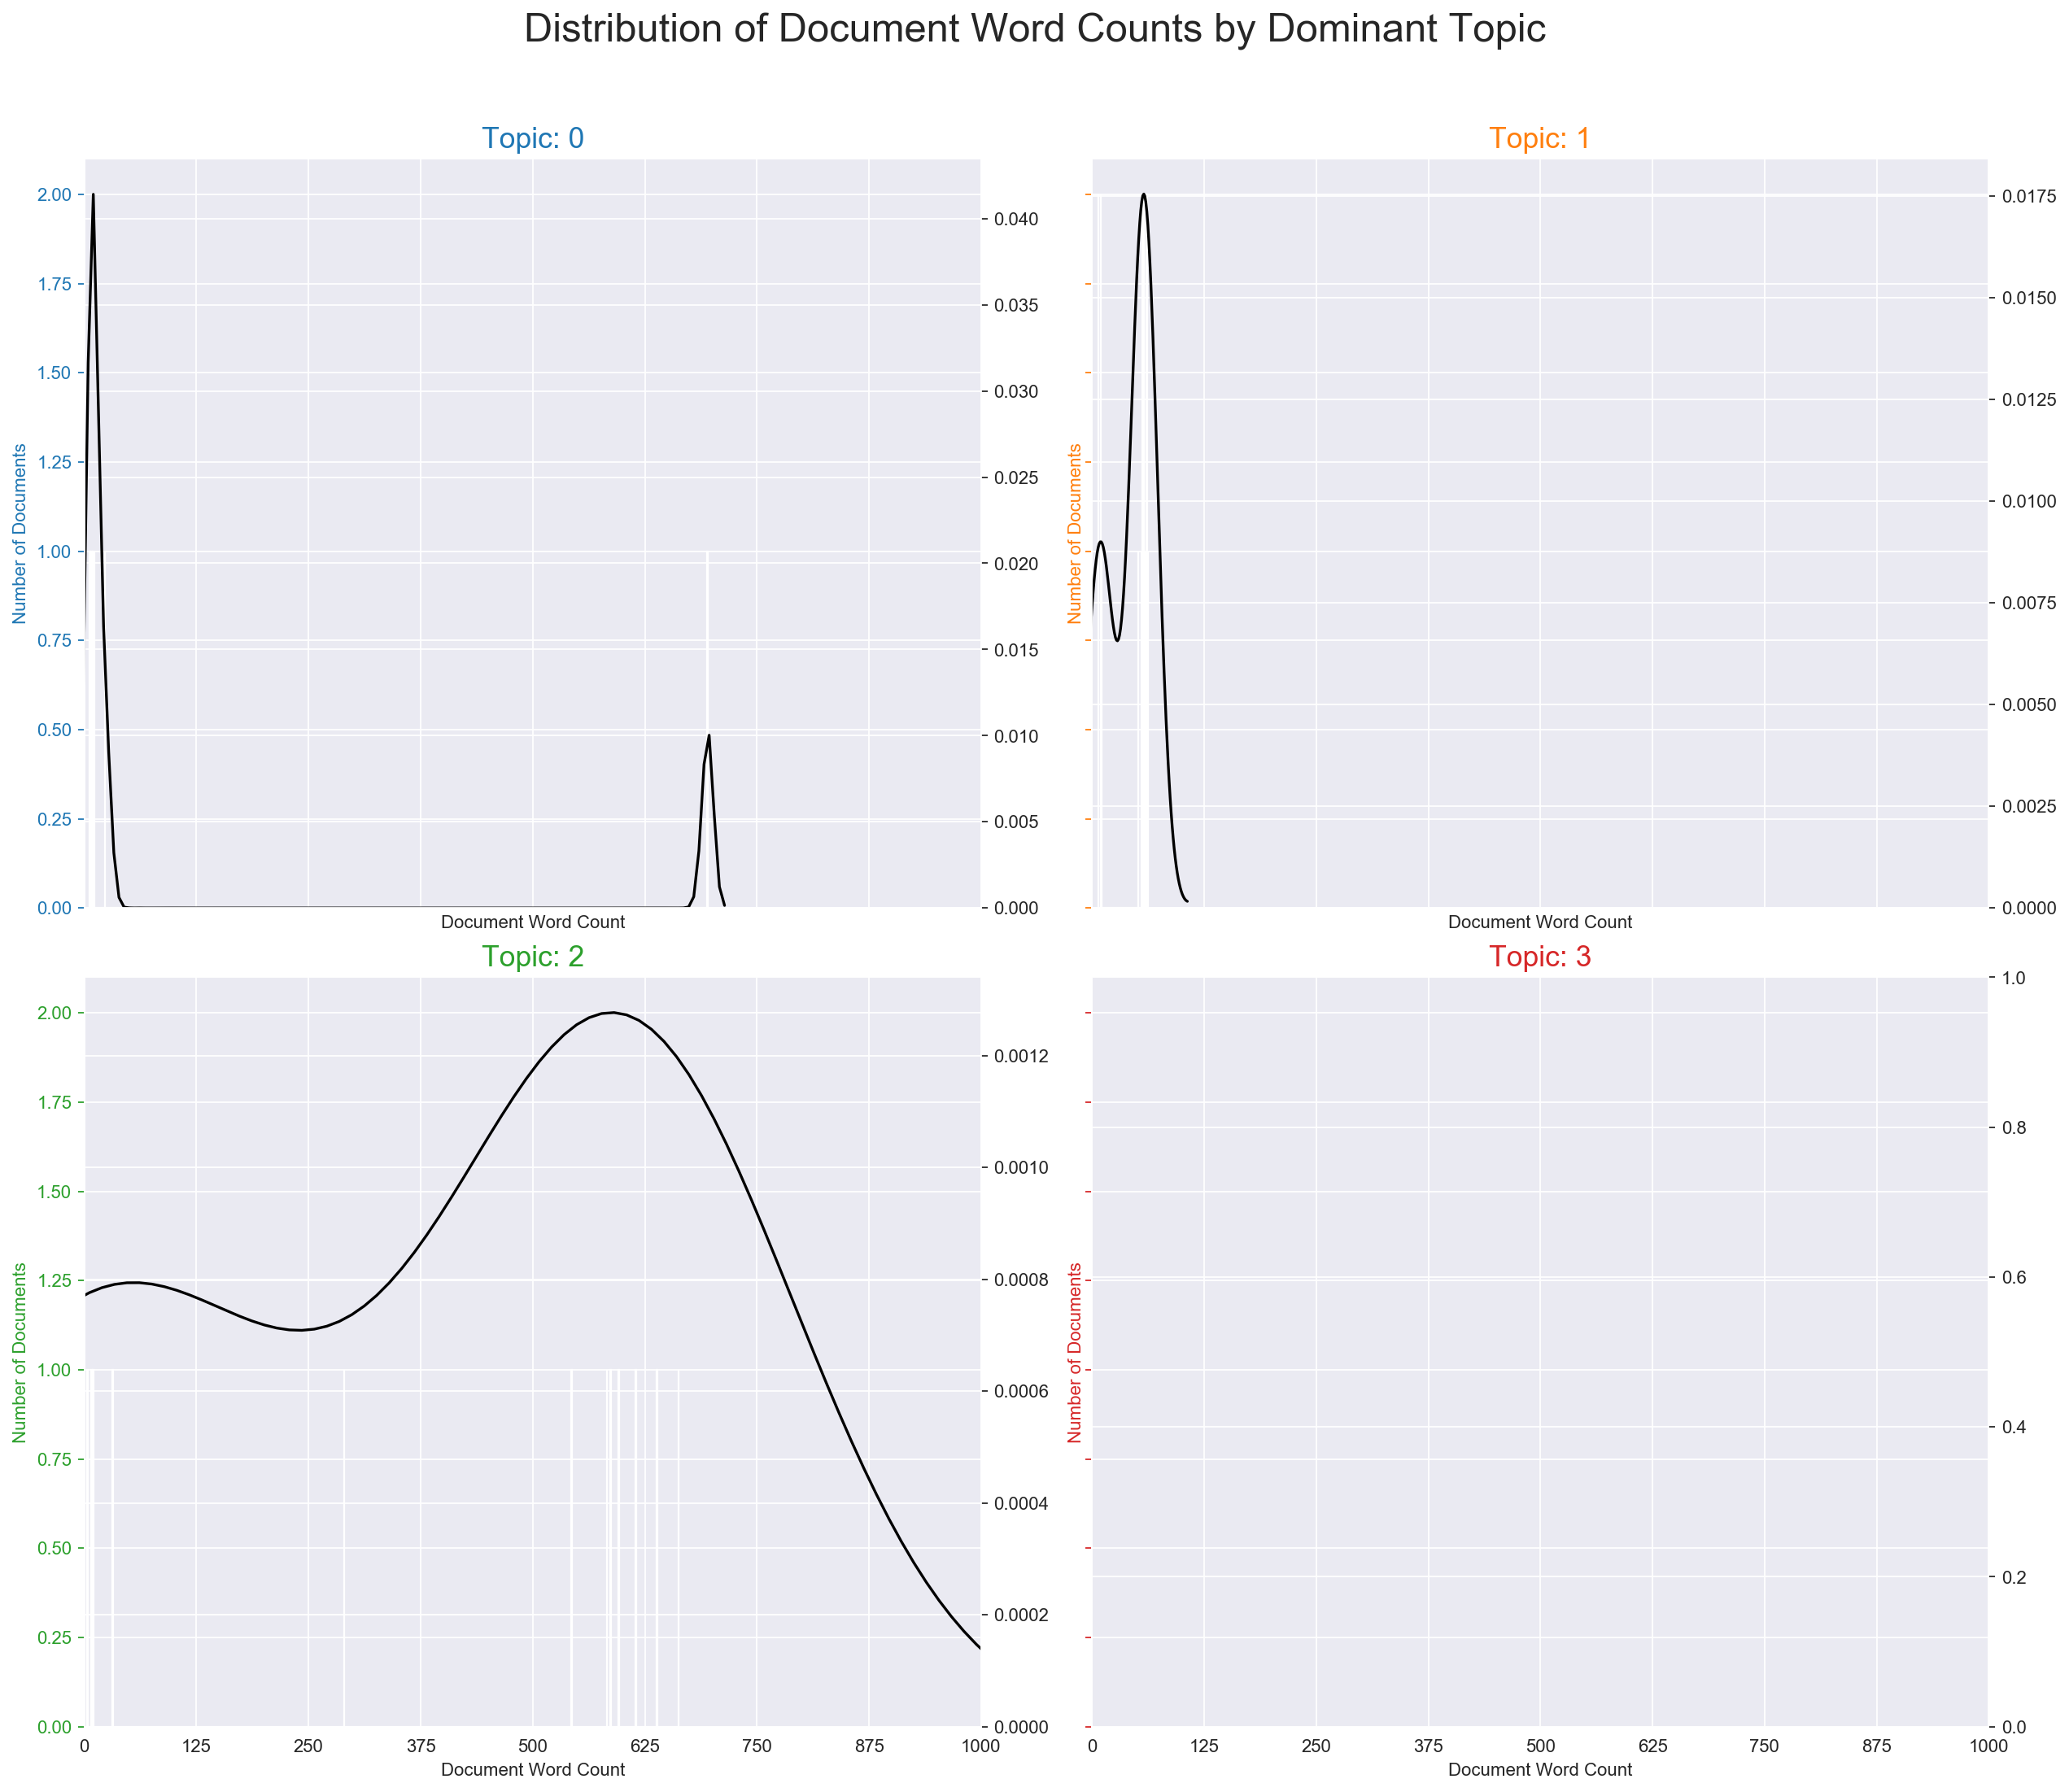

In [68]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

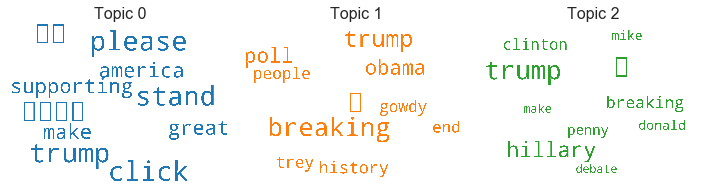

In [69]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Clouds of Top N Keywords in Each Topic


/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10549 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9654 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 10549 missing from current font.
  font.set

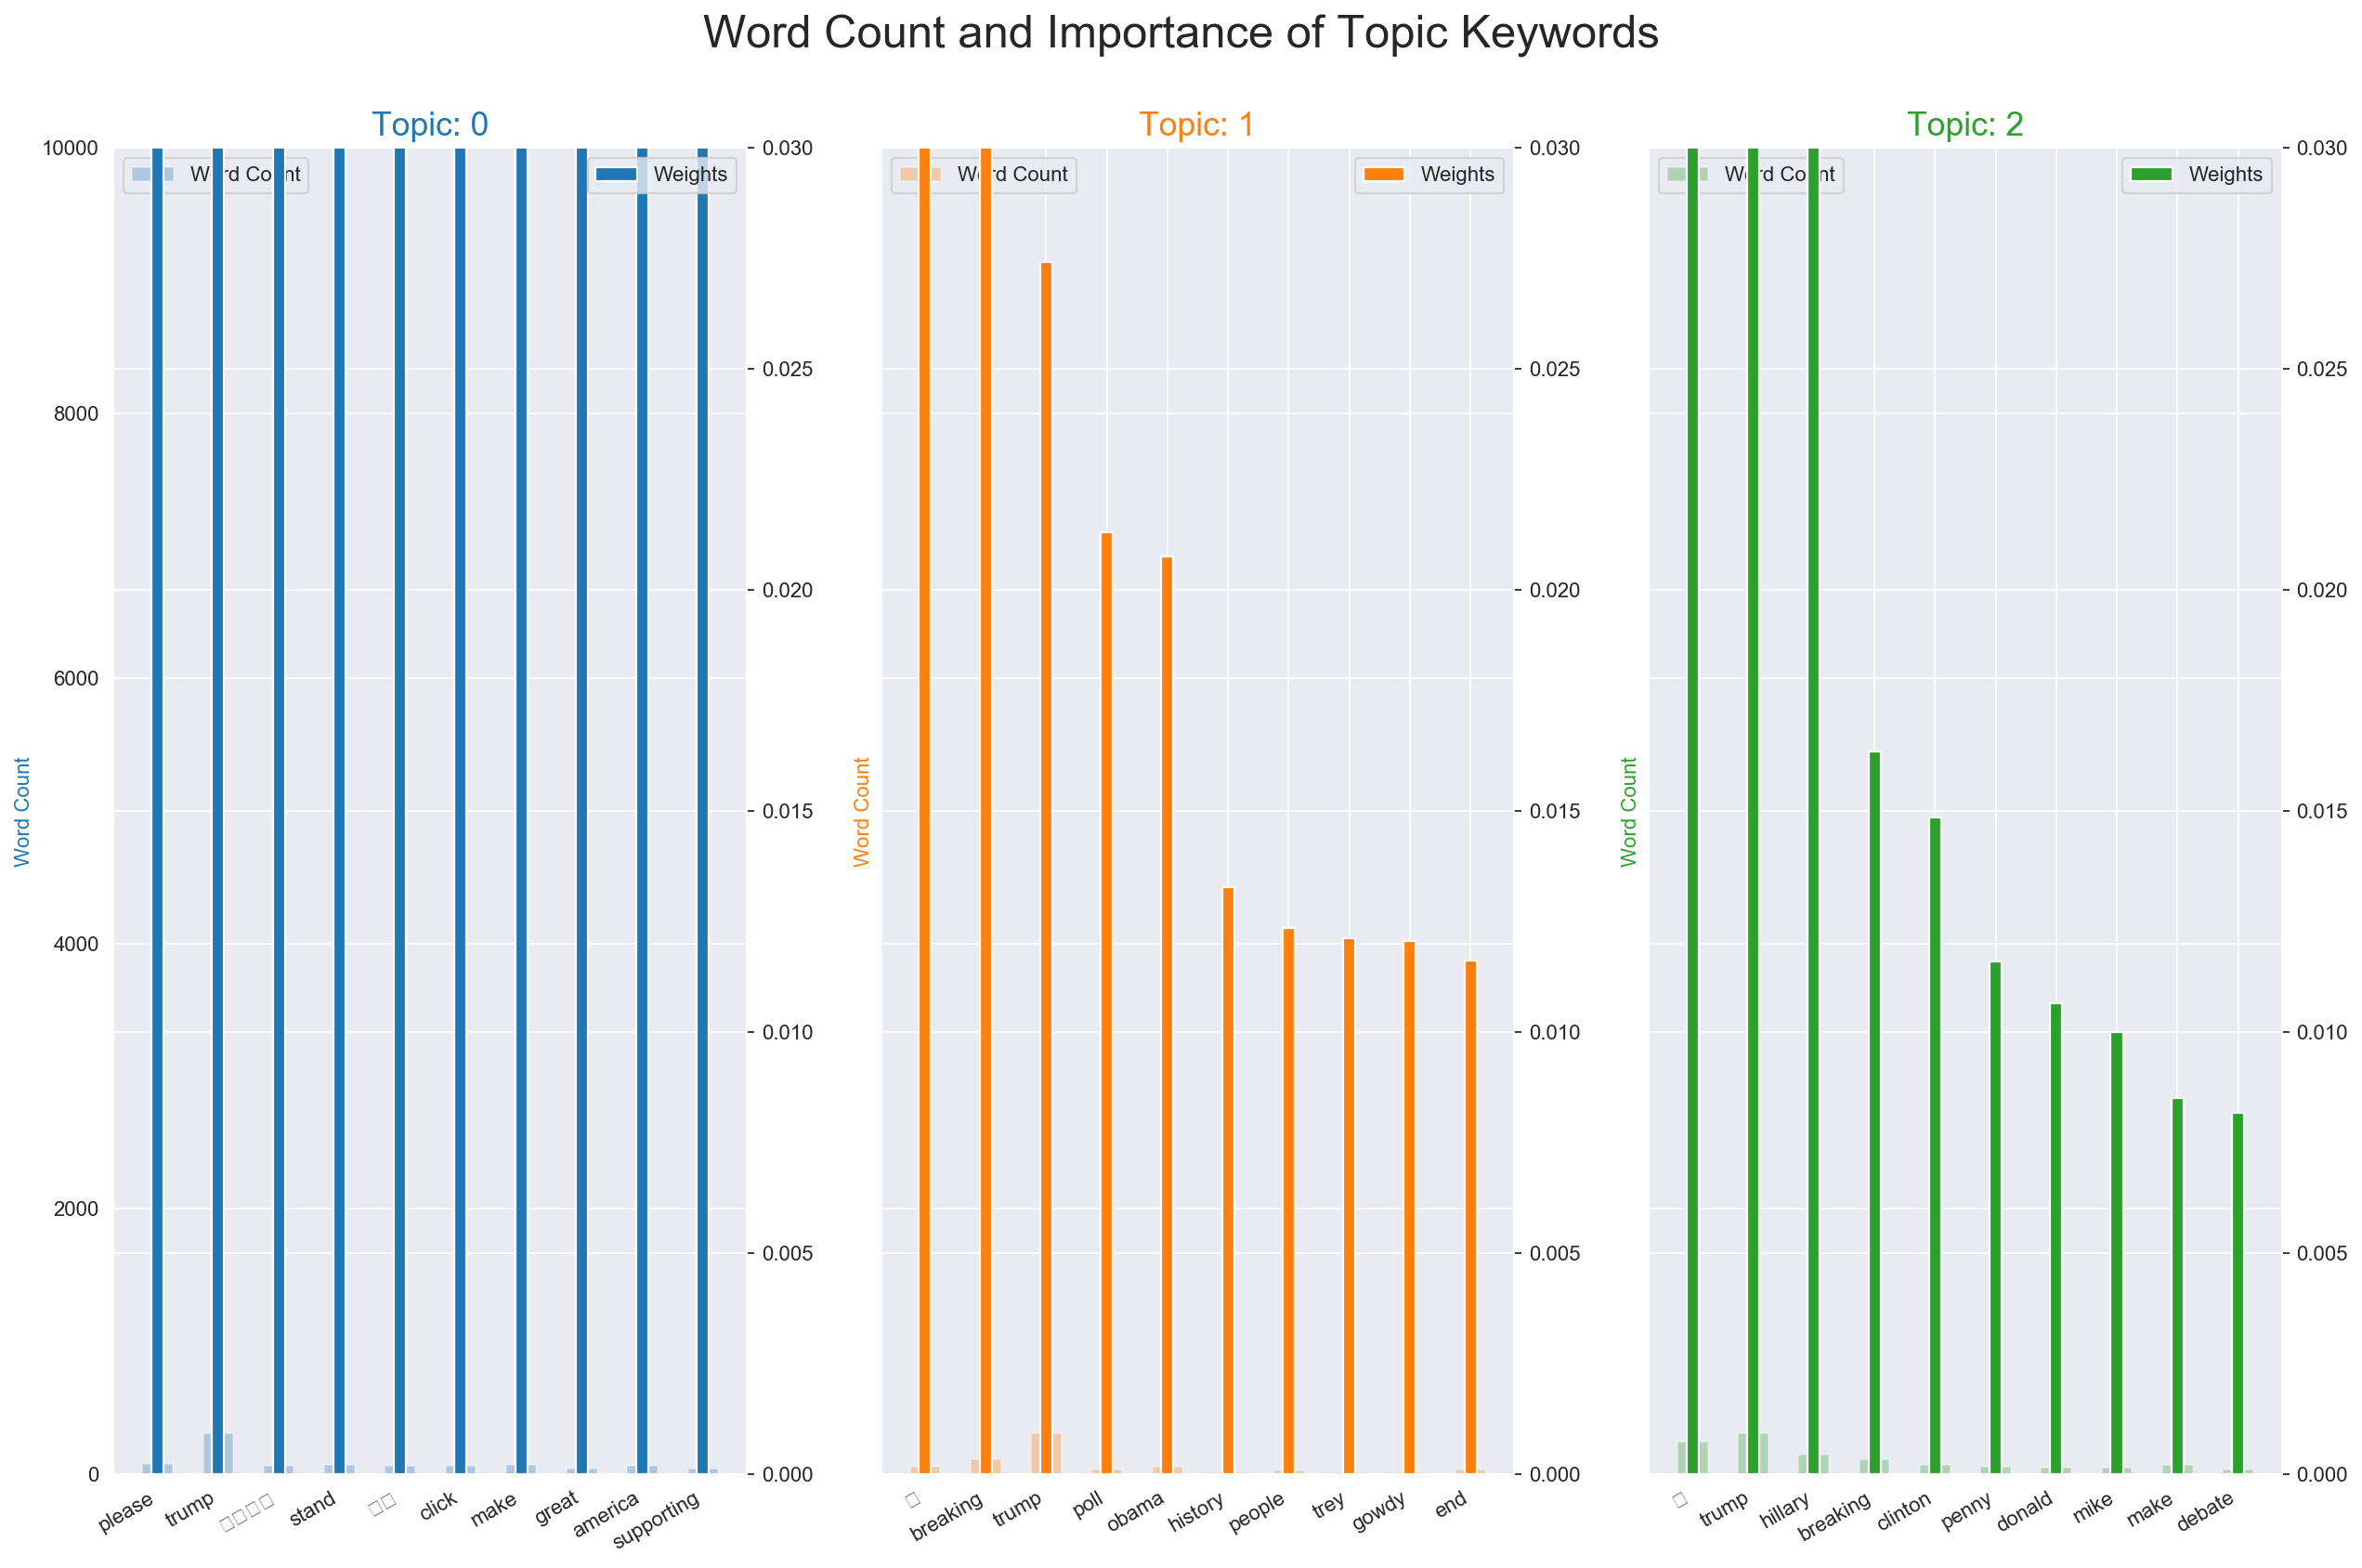

In [70]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in user_tweet_bow for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 10000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Sentence Chart Colored by Topic


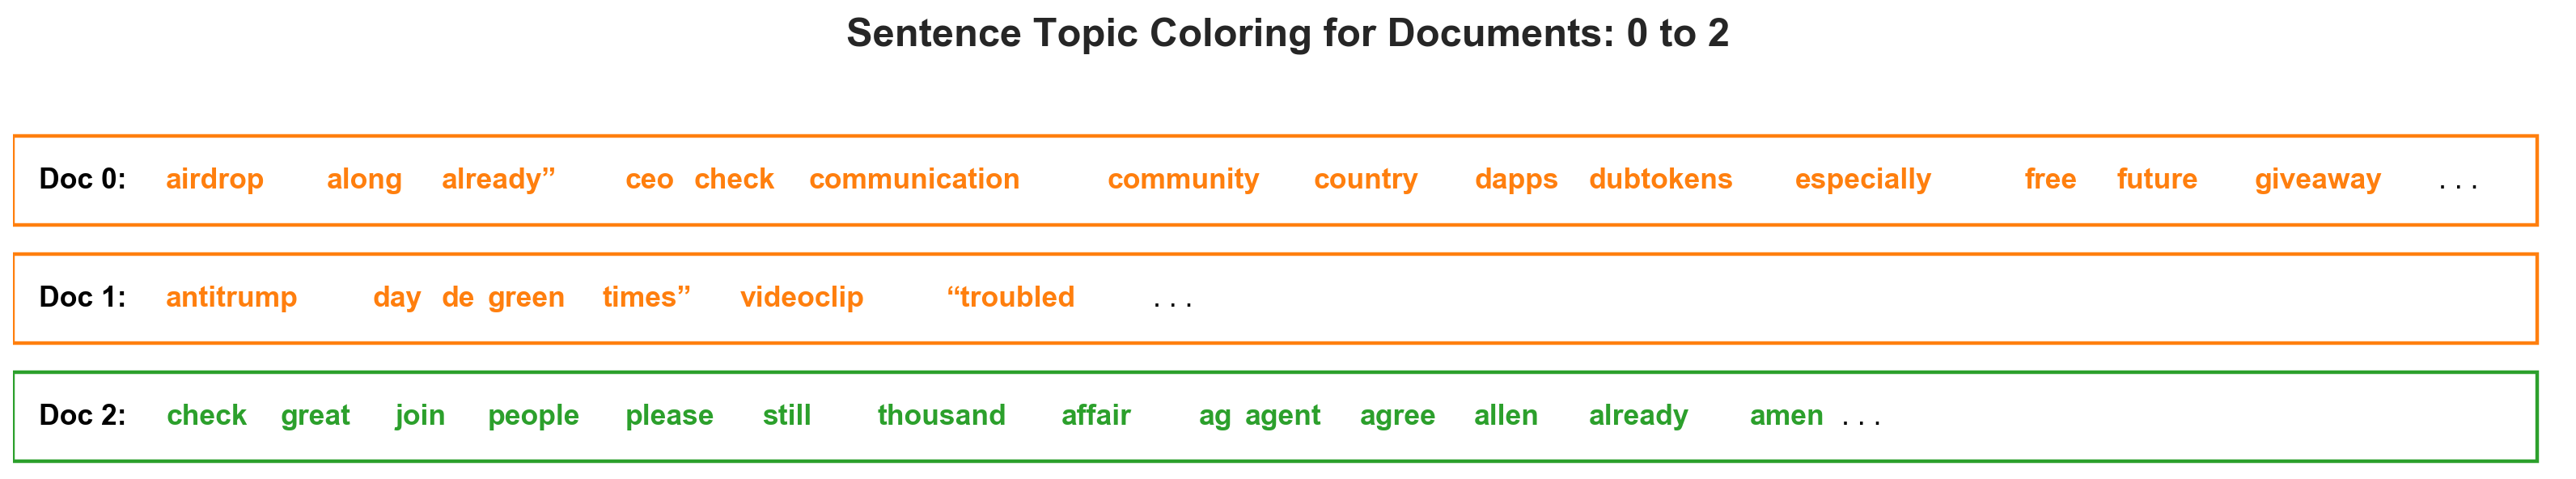

In [71]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 4):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

# What are the most discussed topics in the documents?


In [72]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9654 missing from current font.
  font.set_text(s, 0, flags=flags)


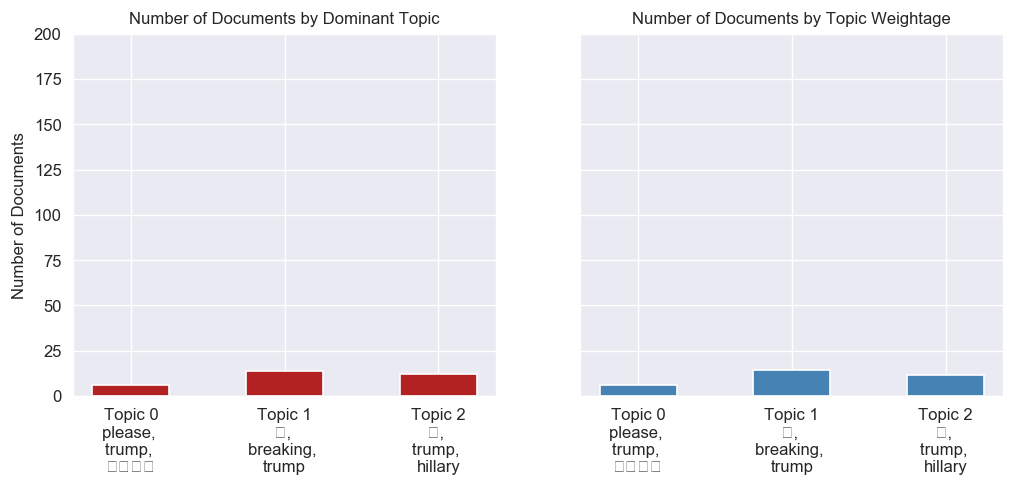

In [73]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 200)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

# t-SNE Clustering Chart

In [74]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 3
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 32 nearest neighbors...
[t-SNE] Indexed 33 samples in 0.000s...
[t-SNE] Computed neighbors for 33 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 33 / 33
[t-SNE] Mean sigma: 1.369428
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.655556
[t-SNE] KL divergence after 1000 iterations: 0.390551


Loading BokehJS ...

In [75]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.099544  0.136436       1        1  74.795250
0      0.238797 -0.014331       2        1  12.690232
1     -0.139253 -0.122105       3        1  12.514514, topic_info=    Category        Freq         Term       Total  loglift  logprob
366  Default  279.000000        trump  279.000000  30.0000  30.0000
24   Default   63.000000       please   63.000000  29.0000  29.0000
339  Default   58.000000        stand   58.000000  28.0000  28.0000
540  Default   47.000000         ⤵️⤵️   47.000000  27.0000  27.0000
530  Default   47.000000        click   47.000000  26.0000  26.0000
503  Default   51.000000           🇺🇸   51.000000  25.0000  25.0000
83   Default   98.000000     breaking   98.000000  24.0000  24.0000
475  Default   46.000000            ️   46.000000  23.0000  23.0000
239  Default   64.000000         make   64.000000  22.0000  22.0000
61   Default   57.000000      america   57.000000  21.0000  21.0000
350  Default   37.000000   supporting   37.000000  20.0000  20.0000
14   Default   35.000000        great   35.000000  19.0000  19.0000
334  Default   32.000000      someone   32.000000  18.0000  18.0000
325  Default   35.000000         show   35.000000  17.0000  17.0000
445  Default   26.000000     movement   26.000000  16.0000  16.0000
529  Default   25.000000         care   25.000000  15.0000  15.0000
533  Default   25.000000         gift   25.000000  14.0000  14.0000
536  Default   25.000000      looking   25.000000  13.0000  13.0000
261  Default   47.000000        obama   47.000000  12.0000  12.0000
275  Default   31.000000         poll   31.000000  11.0000  11.0000
144  Default   33.000000          end   33.000000  10.0000  10.0000
348  Default   31.000000      support   31.000000   9.0000   9.0000
23   Default   21.000000       people   21.000000   8.0000   8.0000
395  Default   26.000000        white   26.000000   7.0000   7.0000
277  Default   35.000000    president   35.000000   6.0000   6.0000
410  Default  239.000000            ▶  239.000000   5.0000   5.0000
79   Default   19.000000    bombshell   19.000000   4.0000   4.0000
435  Default   13.000000      history   13.000000   3.0000   3.0000
465  Default   12.000000         trey   12.000000   2.0000   2.0000
429  Default   12.000000        gowdy   12.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
428   Topic3    8.439543        going   11.952557   1.7303  -4.4788
421   Topic3    8.439003   deepseated   11.952535   1.7302  -4.4788
458   Topic3    8.433863     sharpton   11.954395   1.7294  -4.4794
468   Topic3    8.427736  wiretapping   11.956038   1.7286  -4.4802
417   Topic3    8.410168       border   11.964709   1.7258  -4.4822
474   Topic3    8.392476         “the   11.971447   1.7231  -4.4844
431   Topic3    8.384055       hatred   11.974400   1.7218  -4.4854
438   Topic3    8.364429   impossible   11.984249   1.7187  -4.4877
461   Topic3    8.355836       signed   11.987177   1.7174  -4.4887
436   Topic3    8.333510     history’   11.997025   1.7139  -4.4914
447   Topic3    8.326694       obamas   11.999488   1.7129  -4.4922
463   Topic3    8.321193          tax   12.001098   1.7121  -4.4929
451   Topic3    8.319717      putting   12.003082   1.7117  -4.4931
423   Topic3    8.318264      evasion   12.003223   1.7116  -4.4932
471   Topic3    8.316695       ‘first   12.004679   1.7112  -4.4934
448   Topic3    8.298633      officer   12.011926   1.7085  -4.4956
464   Topic3    8.294675      treason   12.014838   1.7078  -4.4961
439   Topic3    8.290700   indictment   12.016516   1.7071  -4.4966
454   Topic3    8.284291      reveals   12.018256   1.7062  -4.4973
469   Topic3    8.269479       world”   12.024384   1.7039  -4.4991
441   Topic3    8.264848         jail   12.026360   1.7032  -4.4997
433   Topic3    8.257051        heard   12.029581   1.7020  -4.5006
475   Topic3   

# NMF

In [76]:
no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(user_tweet_bag)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [77]:
no_topics = 5

In [78]:
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

In [79]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)


Topic 0:
breaking history obama trump poll gowdy trey support end hit
Topic 1:
hillary trump clinton penny breaking mike donald debate make god
Topic 2:
offensive sickening going freaking gave ge gi gingrich girl god
Topic 3:
user dear join help great check thousand people yuge god
Topic 4:
trump stand movement great america supporting make gowdy girl gave


In [80]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

In [81]:
no_top_words = 4
no_top_documents = 4

In [82]:
# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

In [83]:
# NMF 
display_topics(nmf_H, nmf_W, tfidf_feature_names, user_tweet_bag, no_top_words, no_top_documents)


Topic 0:
breaking history obama trump
family make history baby ultrasound poll support al sharpton going jail tax evasion ️ bombshell signed wiretapping trump treason ️ breaking intel officer reveals obama ‘first president history’ hit felony indictment breaking trump history “the shot heard round world” ️ breaking trey gowdy impossible putting end obamas corruption poll obama deepseated hatred white people border
leaked kpel audio show dems plotting fake display plant lie congressman border poll obama deepseated hatred white people poll support al sharpton going jail tax evasion breaking trump history “the shot heard round world” ️ bombshell signed wiretapping trump treason ️ breaking intel officer reveals obama ‘first president history’ hit felony indictment ️ breaking trey gowdy impossible putting end obamas corruption
hope beel go topless shocking photo ️ breaking trey gowdy impossible putting end obamas corruption ️ bombshell signed wiretapping trump treason border breaking trump 